In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from tensorflow import keras
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler


In [ ]:
df=pd.read_csv("/content/찐막_코로나_한국금리_코스피1.csv",encoding="cp949")


In [ ]:
df['일자']=pd.to_datetime(df['일자'])
df2=df.sort_values("일자")
df2.index=df2['일자']
df2.head()

,Unnamed: 0,일자,X,종가,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액,한국금리,계.명.,국내발생.명.,해외유입.명.,사망.명.,요일,전일대비,누적확진자,deathCnt,defCnt,gubun,gubunCn,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,seq,stdDay,updateDt
일자,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-02,1,2007-01-02,1,1435.26,0.80,0.06,1438.89,1439.71,1430.06,147739,2037041,705331659,4.75,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,2,2007-01-03,2,1409.35,-25.91,-1.81,1436.42,1437.79,1409.31,203208,2611604,692674665,4.75,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,3,2007-01-04,3,1397.29,-12.06,-0.86,1410.55,1411.12,1388.50,241172,2967081,686777867,4.75,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,4,2007-01-05,4,1385.76,-11.53,-0.83,1398.60,1400.59,1372.36,277292,3394972,681185457,4.75,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-08,5,2007-01-08,5,1370.81,-14.95,-1.08,1376.76,1384.65,1366.48,177592,2555241,673840181,4.75,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


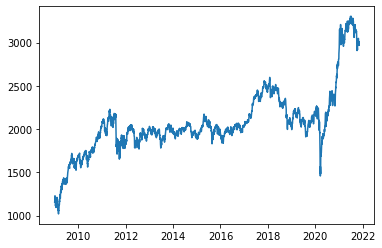

In [ ]:
plt.plot(df2['일자'],df2['종가'])
plt.show()

                 종가
일자                 
2007-01-02  1435.26
2007-01-03  1409.35
2007-01-04  1397.29
2007-01-05  1385.76
2007-01-08  1370.81
...             ...
2019-12-23  2203.71
2019-12-24  2190.08
2019-12-26  2197.93
2019-12-27  2204.21
2019-12-30  2197.67

[3213 rows x 1 columns]


Text(0.5, 1.0, 'Close price change according to date')

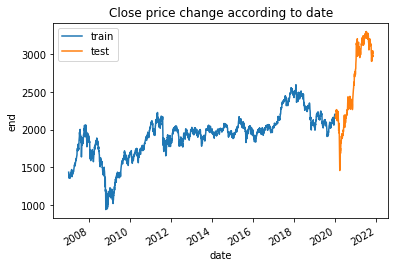

In [ ]:
####데이터 분리 ####
split_date = pd.Timestamp('31-12-2019')
#시가	고가	저가	거래량
train_data=pd.DataFrame(df2.loc[:split_date,['종가']])
test_data=pd.DataFrame(df2.loc[split_date:,['종가']])

print(train_data)

ax=train_data.plot()
test_data.plot(ax=ax)
plt.legend(["train",'test'])
plt.xlabel('date')
plt.ylabel('end')
plt.title("Close price change according to date")

In [ ]:
scaler = MinMaxScaler() 
total=pd.DataFrame(df2['종가'])
total_scale=scaler.fit_transform(total)
train_scale=scaler.fit_transform(train_data)
test_scale= scaler.transform(test_data)

In [ ]:
train_sc_df = pd.DataFrame(train_scale, columns=['Scaled'], index=train_data.index)
test_sc_df = pd.DataFrame(test_scale, columns=['Scaled'], index=test_data.index)
total_sc_df=pd.DataFrame(total_scale, columns=['Scaled'], index=total.index)
####LSTM 의 경우 과거데이터를 어떻게 이용하는가를 파악해야 한다.

for i in range(1, 21): #1달 데이터 기준_이때 20은 통상 주말에 하지 않기 때문에 20일로 window값을
    train_sc_df ['Scaled_{}'.format(i)]=train_sc_df ['Scaled'].shift(i)
    test_sc_df ['Scaled_{}'.format(i)]=test_sc_df ['Scaled'].shift(i)


x_train=train_sc_df.dropna().drop('Scaled', axis=1) #표준화_window
print(x_train)
y_train=train_sc_df.dropna()[['Scaled']]
print(x_train)


x_test=test_sc_df.dropna().drop('Scaled', axis=1)
y_test=test_sc_df.dropna()[['Scaled']]

#nd_array로 변환한다
x_train=x_train.values
x_test=x_test.values

y_train=y_train.values
y_test=y_test.values

            Scaled_1  Scaled_2  Scaled_3  ...  Scaled_18  Scaled_19  Scaled_20
일자                                        ...                                 
2009-02-03  0.081133  0.090732  0.093549  ...   0.111101   0.097988   0.087750
2009-02-04  0.091422  0.081133  0.090732  ...   0.132558   0.111101   0.097988
2009-02-05  0.111791  0.091422  0.081133  ...   0.118331   0.132558   0.111101
2009-02-06  0.100717  0.111791  0.091422  ...   0.102667   0.118331   0.132558
2009-02-09  0.121218  0.100717  0.111791  ...   0.087338   0.102667   0.118331
...              ...       ...       ...  ...        ...        ...        ...
2018-12-21  0.659316  0.671168  0.660576  ...   0.684199   0.673815   0.657644
2018-12-24  0.660183  0.659316  0.671168  ...   0.689771   0.684199   0.673815
2018-12-26  0.656080  0.660183  0.659316  ...   0.693494   0.689771   0.684199
2018-12-27  0.638985  0.656080  0.660183  ...   0.682578   0.693494   0.689771
2018-12-28  0.639257  0.638985  0.656080  ...   0.70

In [ ]:
####LSTM
model = Sequential() #순서형 데이터를 지정
x_train_t = x_train.reshape(x_train.shape[0], 20,1) 
print(x_train_t)

x_test_t = x_test.reshape(x_test.shape[0], 20, 1) 

model.add(LSTM(128,return_sequences=True, input_shape=(20, 1))) # 

# 두번째 LSTM 레이어
model.add(LSTM(128,return_sequences=False))

# 예측값 1개
model.add(Dense(1, activation='linear')) 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

[[[0.0811331 ]
  [0.09073181]
  [0.09354937]
  ...
  [0.11110056]
  [0.09798782]
  [0.08774962]]

 [[0.09142195]
  [0.0811331 ]
  [0.09073181]
  ...
  [0.13255835]
  [0.11110056]
  [0.09798782]]

 [[0.1117907 ]
  [0.09142195]
  [0.0811331 ]
  ...
  [0.11833124]
  [0.13255835]
  [0.11110056]]

 ...

 [[0.65608023]
  [0.66018311]
  [0.65931568]
  ...
  [0.69349365]
  [0.68977067]
  [0.68419886]]

 [[0.63898492]
  [0.65608023]
  [0.66018311]
  ...
  [0.68257797]
  [0.69349365]
  [0.68977067]]

 [[0.63925718]
  [0.63898492]
  [0.65608023]
  ...
  [0.70478289]
  [0.68257797]
  [0.69349365]]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                        

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

#epochs는 훈련 반복 횟수를 지정하고 batch_size는 한 번 훈련할 때 입력되는 데이터 크기를 지정한다.
model.fit(x_train_t, y_train, epochs=40,batch_size=20, verbose=1, callbacks=[early_stop])

y_pred = model.predict(x_test_t)

Epoch 1/40
123/123 [==============================] - 10s 45ms/step - loss: 0.0106
Epoch 2/40
123/123 [==============================] - 5s 44ms/step - loss: 0.0014
Epoch 3/40
123/123 [==============================] - 5s 44ms/step - loss: 0.0015
Epoch 4/40
123/123 [==============================] - 5s 44ms/step - loss: 0.0013
Epoch 5/40
123/123 [==============================] - 5s 44ms/step - loss: 0.0013
Epoch 6/40
123/123 [==============================] - 5s 44ms/step - loss: 0.0012
Epoch 7/40
123/123 [==============================] - 5s 44ms/step - loss: 0.0011
Epoch 8/40
123/123 [==============================] - 5s 43ms/step - loss: 0.0010
Epoch 9/40
123/123 [==============================] - 5s 44ms/step - loss: 8.9782e-04
Epoch 10/40
123/123 [==============================] - 5s 43ms/step - loss: 8.0746e-04
Epoch 11/40
123/123 [==============================] - 6s 45ms/step - loss: 7.0868e-04
Epoch 12/40
123/123 [==============================] - 5s 44ms/step - loss: 6.4169e

Text(0.5, 1.0, 'not_covid_to2018')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)


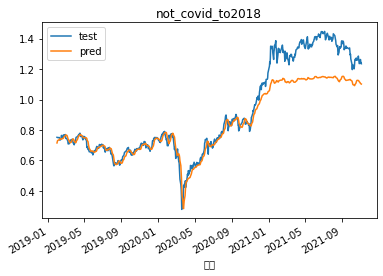

In [ ]:
t_df=test_sc_df.dropna()
y_pred
y_test_df=pd.DataFrame(y_test, columns=['close'], index=t_df.index)
y_pred_df=pd.DataFrame(y_pred, columns=['close'], index=t_df.index)

ax1=y_test_df.plot()
y_pred_df.plot(ax=ax1)
plt.legend(['test','pred'])
plt.title("not_covid_to2018") #갑작스러운 변동에 대비하지 못하는 것을 알 수 있음

Text(0.5, 1.0, '2020~2021_test')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)


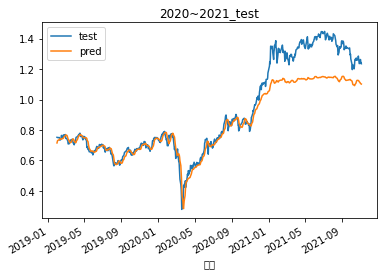

In [ ]:
t_df=test_sc_df.dropna()
y_pred
y_test_df=pd.DataFrame(y_test, columns=['close'], index=t_df.index)
y_pred_df=pd.DataFrame(y_pred, columns=['close'], index=t_df.index)

ax1=y_test_df.plot()
y_pred_df.plot(ax=ax1)
plt.legend(['test','pred'])
plt.title("2020~2021_test")

In [ ]:
print(model.evaluate(x_train_t, y_train,batch_size=30))

82/82 [==============================] - 1s 16ms/step - loss: 4.3944e-04
0.00043943998753093183


In [ ]:
x_train_t

array([[[0.0811331 ],
        [0.09073181],
        [0.09354937],
        ...,
        [0.11110056],
        [0.09798782],
        [0.08774962]],

       [[0.09142195],
        [0.0811331 ],
        [0.09073181],
        ...,
        [0.13255835],
        [0.11110056],
        [0.09798782]],

       [[0.1117907 ],
        [0.09142195],
        [0.0811331 ],
        ...,
        [0.11833124],
        [0.13255835],
        [0.11110056]],

       ...,

       [[0.65608023],
        [0.66018311],
        [0.65931568],
        ...,
        [0.69349365],
        [0.68977067],
        [0.68419886]],

       [[0.63898492],
        [0.65608023],
        [0.66018311],
        ...,
        [0.68257797],
        [0.69349365],
        [0.68977067]],

       [[0.63925718],
        [0.63898492],
        [0.65608023],
        ...,
        [0.70478289],
        [0.68257797],
        [0.69349365]]])

ImportError: ignored